#K-Means Clustering - Handwritten Digits
##Brady Young

---

For this project I implemented a K-Means clusterer that classifies input based on its distance from each cluster center. In order to train the model, the centers are updated to the mean values of their cluster at the end of each epoch. Once the centers have stopped moving, the training is finished and the model is ready for testing.

Two different clusterers are created in this project, one with 10 clusters (which equals the number of classes), and another with 30 clusters. The results of testing both models are listed below.

# Implementation

## Modules

In [0]:
import numpy as np                #Used for array operations
import heapq                      #Used to find indexes of highest values
import time                       #Used to seed RNG
import matplotlib.pyplot as plt   #Used to plot data
import math                       #Used for log
import requests                   #Used to download dataset
import os                         #Used to manage filesystem
import random as rand             #Used to choose initial clusters
import zipfile                    #Used to unzip dataset

## Data Acquisition, Preprocessing, and Plotting

In [0]:
#Creates directory for writing data files
if(os.path.isdir('data') == False):
  os.makedirs('data')
  
  #Writes dataset and remote location to local files
  link = 'http://web.cecs.pdx.edu/~mm/MachineLearningWinter2019/optdigits.zip'
  r = requests.get(link)
  with open('optdigits.zip', 'wb') as file:
    file.write(r.content)
  
  #Unzip the files
  zip_ref = zipfile.ZipFile('optdigits.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  #Remove the zip file, we're done with it
  os.remove('optdigits.zip')

### Dataset

In [0]:
#A wrapper to process the dataset after reading
class Dataset:
  def __init__(self):
    self.trainset = []
    self.testset = []
    self.goalset = []
    self.testgoalset = []
    
    self.load()

  #Copies the data into memory
  def load(self):
    buffer = []
    
    #Training Set
    with open('data/optdigits/optdigits.train', mode='r') as file:
      buffer = file.read()
    
    for features in buffer.split('\n'):
      self.trainset.append(features.split(','))
      self.goalset.append(self.trainset[-1])
      
    #Test Set
    with open('data/optdigits/optdigits.test', mode='r') as file:
      buffer = file.read()
      
    for features in buffer.split('\n'):
      self.testset.append(features.split(','))
      self.testgoalset.append(self.testset[-1])
    
    
    #Remove empty instance at end
    self.testset.pop()
    self.trainset.pop()
    self.testgoalset.pop()
    self.goalset.pop()

### Plotting

In [0]:
def confusion_matrix(confMat):
  #Simple table representing error rates for individual digits
  cellHeight = 0.1
  cellWidth = 0.1
  rowLabel = list(range(10))
  colLabel = rowLabel

  tb = plt.table(cellText=confMat, rowLabels=rowLabel, colLabels=colLabel, loc=(0,0), cellLoc='center')
  plt.title("Confusion Matrix", y=1.08)
  tc = tb.properties()['child_artists']
  for cell in tc: 
    cell.set_height(cellHeight)
    cell.set_width(cellWidth)
    
  plt.xlabel("Target", labelpad = 5)
  plt.ylabel("Output", labelpad = 5)
  plt.xticks([])
  plt.yticks([])

  plt.draw()
  plt.show()
  

## K-Means Clusterer

In [0]:
class KMeans:
  def __init__(self, num_clusters, dataset):
    self.num_clusters = num_clusters
    self.data = dataset
    
    #Shorten data variable name length
    self.setDataAliases()
    
    #Choose centers
    rand.seed(time.gmtime())
    self.centers = rand.sample(self.train, self.num_clusters)
    
    #Change from lists to numpy arrays
    self.adjustDatatype()
    
    
    #Execution
    self.assignClusters()
    while(self.moveCenters()): 
      self.assignClusters()
    
    
    # Associate a class with each center of cluster
    self.center_class = np.zeros(self.num_clusters)
    self.assignCenters()
    
    # Evaluate model
    self.accuracy = 0
    self.conf_matrix = np.zeros((10, 10), dtype='int')
    self.testCenters()
    self.calcStats()
    
    
  #Prints the results  
  def __repr__(self):
    print("Accuracy:\t", self.accuracy)
    print("MSE:\t\t", self.MSE)
    print("MSS:\t\t", self.MSS)
    print("Entropy:\t", self.entropy)
    confusion_matrix(self.conf_matrix)
    return ""
  
  
  # Shorten data variable names
  def setDataAliases(self):
    self.train = self.data.trainset
    self.train_goal = self.data.goalset
    self.test = self.data.testset
    self.test_goal = self.data.testgoalset
  
  
  # Change data from lists to np arrays
  def adjustDatatype(self):
    self.train = np.array(self.train, dtype='int')
    self.train_goal = np.array(self.train_goal, dtype='int')
    self.test = np.array(self.test, dtype='int')
    self.test_goal = np.array(self.test_goal, dtype='int')
    
    for i in range(self.num_clusters):
      self.centers[i] = np.array(self.centers[i], dtype='int')[:-1]
      
      
  # Associate each instance with a cluster based on closest center
  def assignClusters(self):
    # Reset the clusters
    self.clusters = [[] for i in range(self.num_clusters)]
    
    # Add instance to cluster
    for instance in self.train:
      self.addToCluster(self.findClosestCenter(instance), instance)
    
    
  # Returns the index of the center the instance is closest to
  # using euclidean distance
  def findClosestCenter(self, instance):
    sub = self.centers - instance[:-1]
    sub = sub ** 2
    sub = np.sum(sub, axis=1)
    sub = np.sqrt(sub)
    sub = list(sub)
    return sub.index(min(sub))
  
  
  # Adds an instance to a cluster
  def addToCluster(self, index, instance):
    self.clusters[index].append(np.array(instance, dtype='int'))
  
  
  # Adjusts the centers to averages of cluster values
  def moveCenters(self):
    new_centers = []
    changed = False
    
    for cluster in self.clusters:
      cluster = np.array(cluster, 'int')
      mean = np.array(np.mean(cluster, axis=0), 'int')
      
      # Leave off the mean class for the center
      new_centers.append(mean[:-1])
      
    # Check if centers have moved
    for i in range(len(new_centers)):
      if(np.array_equal(new_centers[i], self.centers[i])):
         changed = True
      
    self.centers = []
    self.centers = np.array(new_centers, dtype='int')
    return changed
  

  # Associates a center with a class
  def assignCenters(self):
    for i in range(self.num_clusters):
      count = [0] * 10
      for instance in self.clusters[i]:
        count[instance[-1]] += 1
        
      largest = np.argsort(count)[::-1][:len(count)]
      
      cluster_class = largest[0]
      largest = largest[1:]
      
      self.center_class[i] = cluster_class
      

  # Evaluate the model with the test dataset
  def testCenters(self):
    for i in range(len(self.test)):
      result = int(self.center_class[self.findClosestCenter(self.test[i])])
      target = self.test[i][-1]
      
      if(result == target):
        self.accuracy += 1
        
      self.conf_matrix[result][target] += 1
      
    self.accuracy = self.accuracy / len(self.test)
    
  
  # Wrapper to calculate the statistics of the model
  def calcStats(self):
    self.calcMSE()
    self.calcMSS()
    self.calcEntropy()
    
    
  # Calculates mean-square-error of the model
  def calcMSE(self):
    diff = np.zeros(64)
    for i in range(self.num_clusters):
      for cluster in self.clusters[i]:
        diff += (cluster[:-1] - self.centers[i]) ** 2
      
    
    self.MSE = (np.sum(diff) / len(self.train)) / self.num_clusters
      
  
  # Calculates the mean-square-separation of the model
  def calcMSS(self):
    total_sum = 0
    for i in range(self.num_clusters):
      other_centers = list(self.centers)
      other_centers.pop(i)
      center_sum = 0
      
      for center in other_centers:
        center_sum = np.sum((self.centers[i][:-1] - center[:-1])**2)
      total_sum += center_sum
      
    denom = (self.num_clusters * self.num_clusters-1) / 2
    self.MSS = total_sum / denom
     
      
  # Calculates the entropy of the model
  def calcEntropy(self):
    total_entropy = 0
    for cluster in self.clusters:
      class_total = np.zeros(10)
      cluster_entropy = 0
      
      for instance in cluster:
        class_total[instance[-1]] += 1
        
      for total in class_total:
        if(total > 0):
          prob = total / np.sum(class_total)
          cluster_entropy -= prob * math.log(prob)
      
      total_entropy += cluster_entropy
    
    self.entropy = total_entropy

# Execution

## 10 Clusters

In [0]:
trials = []
min_MSE = []
data = Dataset()
CLUSTERS = 10

for i in range(5):
  trials.append(KMeans(CLUSTERS, data))
  min_MSE.append(trials[-1].MSE)
  
best10 = trials[min_MSE.index(min(min_MSE))]

### Visualized Centers

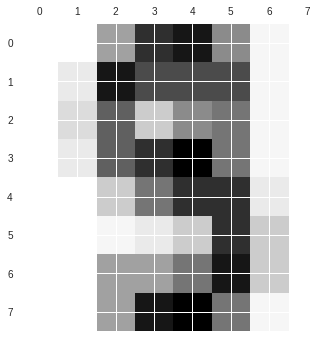

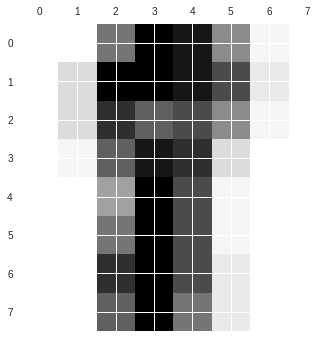

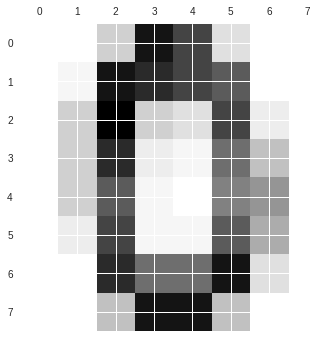

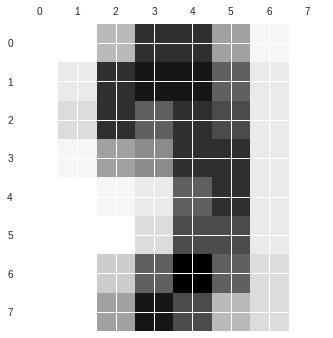

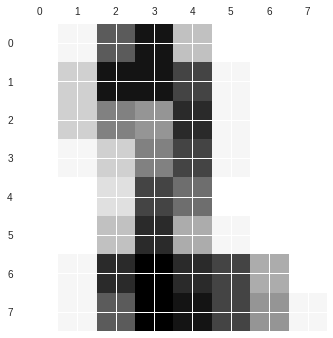

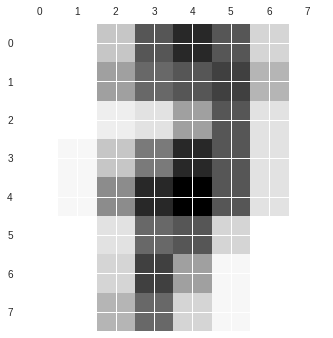

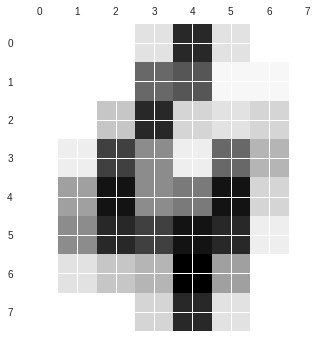

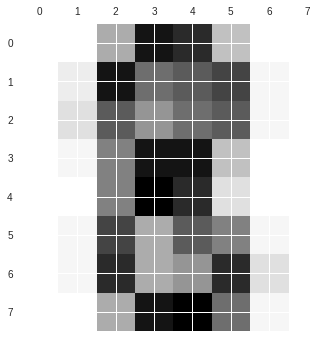

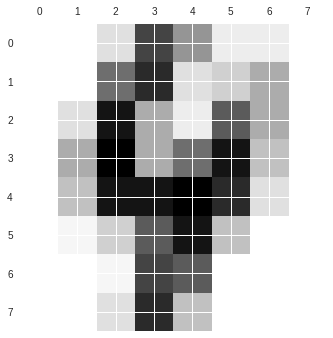

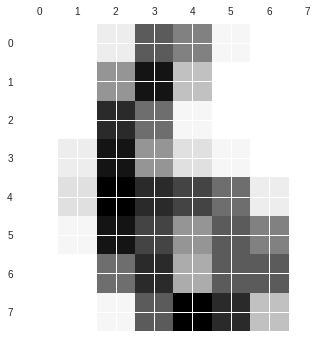

In [0]:
# Display matrix
for center in best10.centers:
  plt.matshow(np.reshape(center,(8,8)))
plt.show()

### Model Statistics

Accuracy:	 0.6499721758486366
MSE:		 77.51119539628564
MSS:		 244.82828282828282
Entropy:	 9.735508256090469


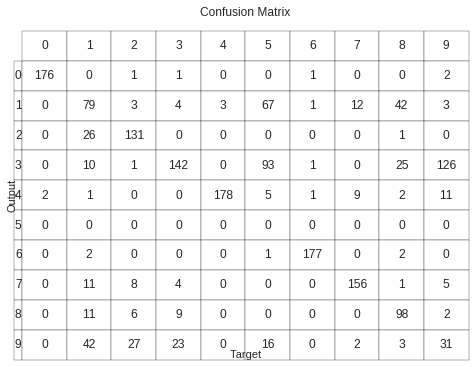

In [0]:
print(best10)

## 30 Clusters

In [0]:
trials = []
min_MSE = []
data = Dataset()
CLUSTERS = 30

for i in range(5):
  trials.append(KMeans(CLUSTERS, data))
  min_MSE.append(trials[-1].MSE)
  
best30 = trials[min_MSE.index(min(min_MSE))]

### Visualized Centers

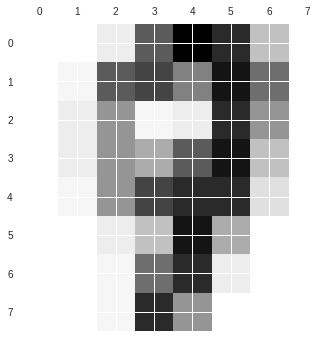

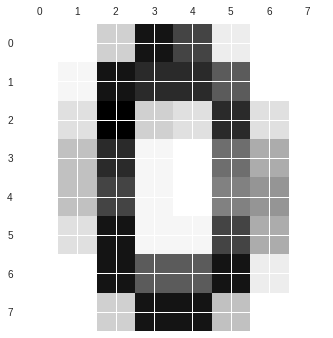

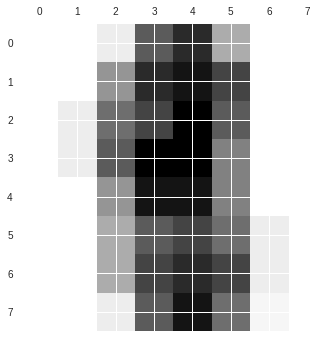

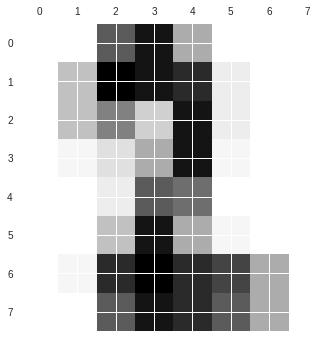

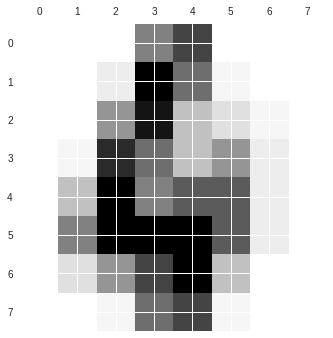

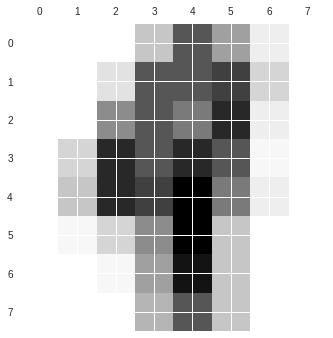

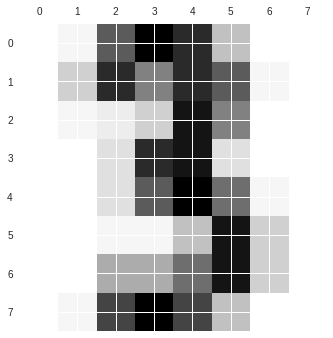

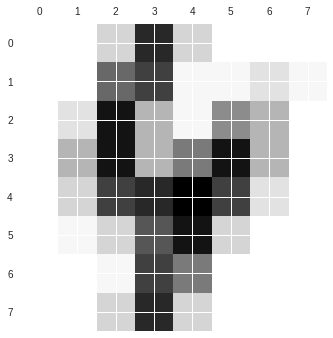

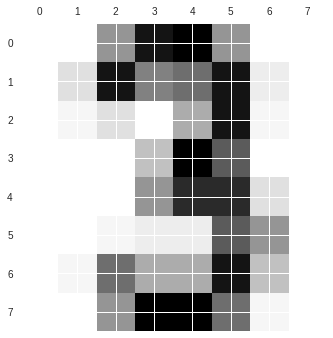

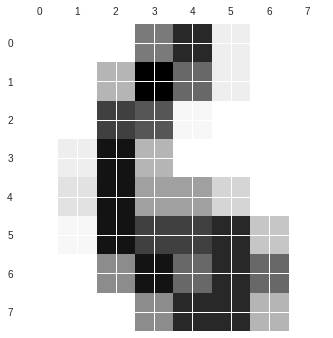

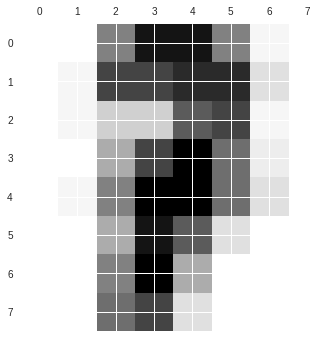

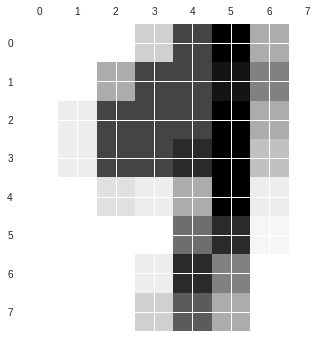

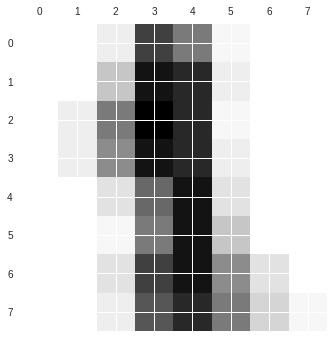

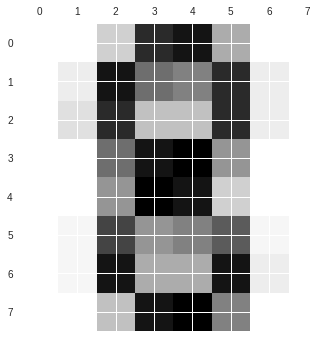

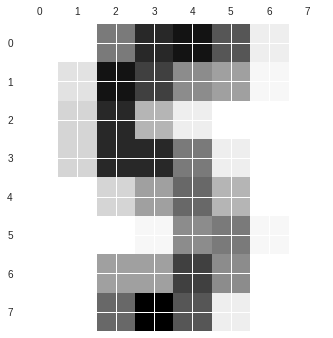

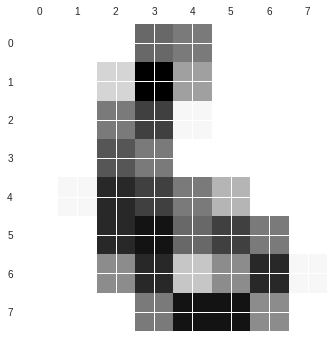

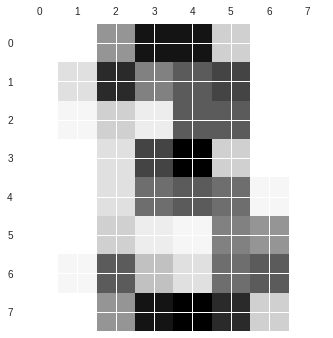

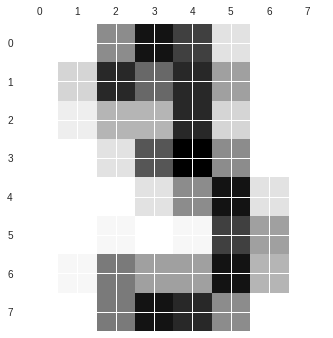

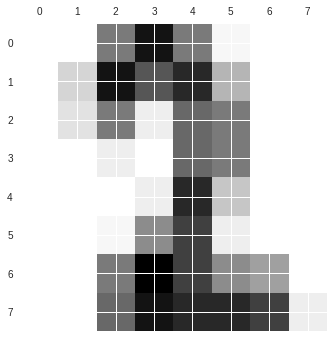

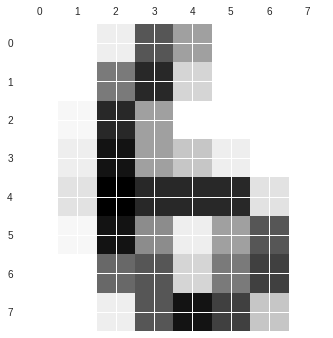

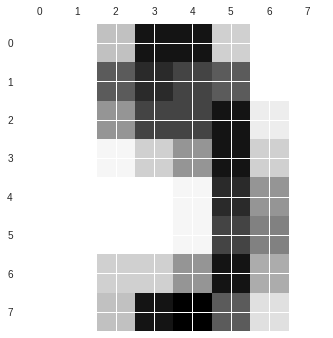

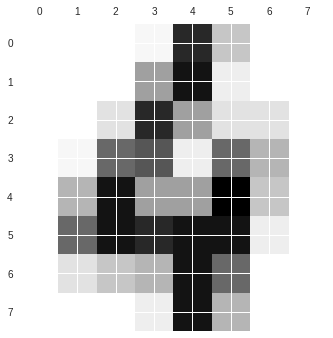

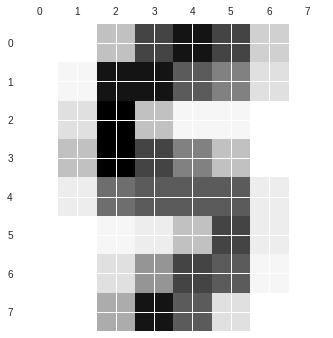

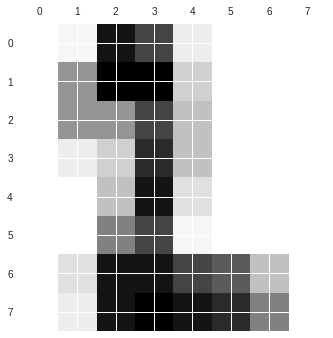

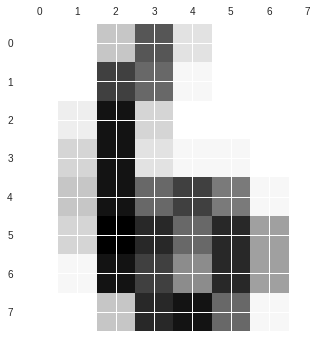

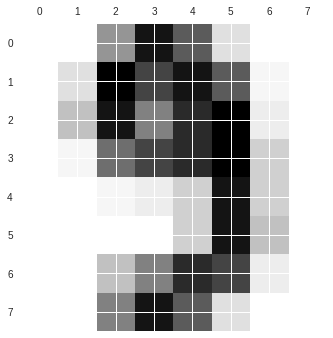

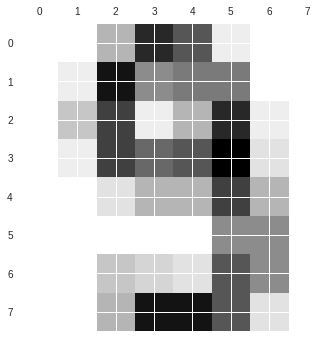

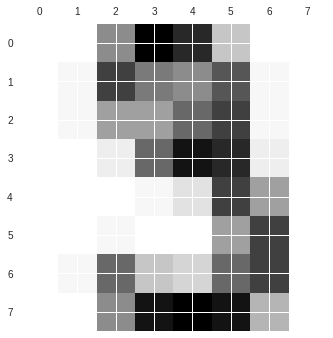

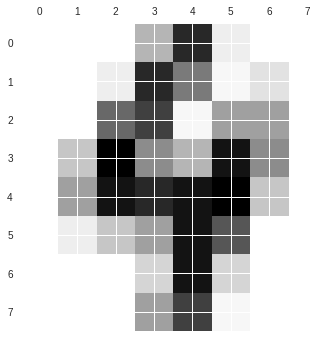

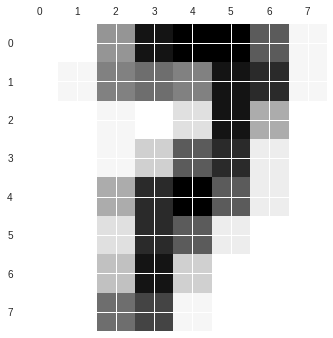

In [0]:
#Remove warning due to number of figures rendered
plt.rcParams.update({'figure.max_open_warning': 0})

# Display matrix
for center in best30.centers:
  plt.matshow(np.reshape(center,(8,8)))
plt.show()

### Model Statistics

Accuracy:	 0.8703394546466333
MSE:		 19.419068794140728
MSS:		 120.35817575083426
Entropy:	 17.38639249363646


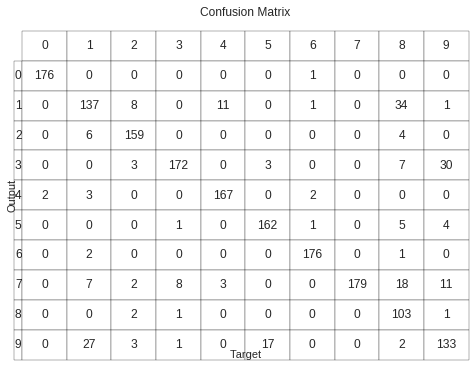

In [0]:
print(best30)

# Results

10 Clusters
 Accuracy:	 0.6499721758486366
MSE:		 77.51119539628564
MSS:		 244.82828282828282
Entropy:	 9.735508256090469


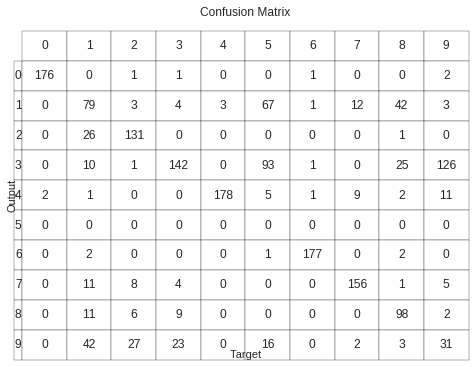


30 Clusters
 Accuracy:	 0.8703394546466333
MSE:		 19.419068794140728
MSS:		 120.35817575083426
Entropy:	 17.38639249363646


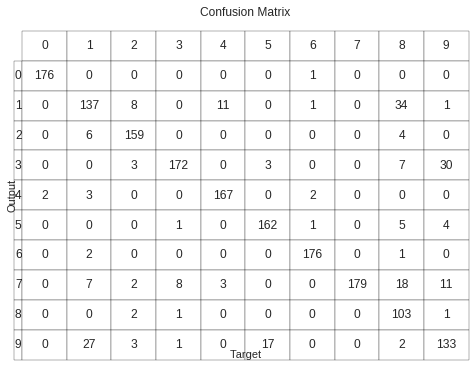

In [0]:
print("10 Clusters\n", best10)
print("30 Clusters\n", best30)

## 10 Clusters

This model has decent accuracy despite it consisting of just ten clusters, however its performance is highly dependent on the initial position of its centers. Iterations of the model with different seeds result in a wide variance of model accuracy.

Looking at the visualized centers, certain visual features of specific numbers can be identified. Some of the clusters show a mixture of number features, and some resemble numbers already associated with a different cluster. I suppose this might be due to two centers overlapping one another. For example, a certain visual style of 6 might be closer to one cluster, while another style is closer to a different cluster. This would split a class between two clusters. For a model with only just enough clusters to account for each class, this effectively "steals" a cluster from a class and limits the models accuracy.

## 30 Clusters

Compared to the model with only 10 clusters, the MSE and MSS are lower, while the entropy is higher. The lower MSE indicates that the centers of the clusters are closer to the instances that belong to it, better fitting the data. The lower MSS is not surprising, as the more clusters there are distributed through the feature space, the less space is possible for them to be apart from each other.

Due to the increase in the number of clusters, overlapping is less of an issue, as there are now several clusters that can describe any given class. Different visual styles of a number can now belong to their own cluster without affecting the accuracy for other classes. While this does not guarentee that each class will have at minimum one cluster, the core features that describe a given number should have more weight to them than the accessory features.